# Putting the G in RAG

In [31]:
from supabase import create_client, Client
import datetime
from pinecone import Pinecone, ServerlessSpec

from typing import Dict, Optional, Any
import os
from openai import OpenAI
import pandas as pd

from pydantic import BaseModel, Field
from typing import List, Dict, Tuple

from dotenv import load_dotenv

In [32]:
load_dotenv()

url: str = os.getenv("SUPABASE_URL")
key: str = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [33]:
# Initialize the OpenAI client with the API key from user data
openai_client = OpenAI(api_key=os.environ.get('OPENAI_API_KEY'))

In [34]:
pinecone_key = os.environ.get('PINECONE_API_KEY')
INDEX_NAME = 'semantic-search-rag-index'
ENGINE = 'text-embedding-3-small'
NAMESPACE = 'default'

pc = Pinecone(
    api_key=pinecone_key
)

# helper functions to get lists of embeddings from the OpenAI API
def get_embedding(text, engine=ENGINE):
    response = openai_client.embeddings.create(
        input=[text],
        model=engine
    )
    return response.data[0].embedding

len(get_embedding('hi'))

1536

In [35]:
# Store the index as a variable
index = pc.Index(name=INDEX_NAME)
index

In [41]:
def query_from_pinecone(query, top_k=1, include_metadata=True):
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

len(query_from_pinecone('KulturHighlights in Munchen'))

1

In [42]:
query_from_pinecone('KulturHighlights in Munchen')

[{'id': '6ad9eeafc1a442c0a4c67b832832e3bf',
  'metadata': {'date_uploaded': '2025-05-19T16:46:49.896040',
               'text': 'us KulturHighlights Perlen der Münchner Kultur '
                       'Konzertsäle, Museen, Theater HotelÜbersicht Unterkünfte '
                       'in allen Preislagen buchen Hier im Überblick '
                       'Sehenswürdigkeiten Bauwerke, Kirchen, Schlösser, Parks '
                       'So schön ist München München mal anders Eure '
                       'Stadtführung durch München mit oder ohne Guide LGBTIQ '
                       'in München Tipps und Informationen für die queere '
                       'Community Sehenswerte UBahnStationen Kunstwerke im '
                       'Untergrund Sehenswerte UBahnhöfe Immer einen Besuch '
                       'wert Museen in München Die wichtigsten Museen und '
                       'Galerien Münchens Olympiapark Erholen, Staunen, Erleben '
                       'im weitläufigen Park Be

In [24]:
FINAL_ANSWER_TOKEN = "Assistant Response:"
STOP = '[END]'
PROMPT_TEMPLATE = """Today is {today} and you can retrieve information from a database. Respond to the user's input as best as you can.

Here is an example of the conversation format:

[START]
User Input: the input question you must answer
Context: retrieved context from the database
Context URL: context url
Context Score : a score from 0 - 1 of how strong the information is a match
Assistant Thought: This context has sufficient information to answer the question.
Assistant Response: your final answer to the original input question which could be I don't have sufficient information to answer the question.
[END]
[START]
User Input: another input question you must answer
Context: more retrieved context from the database
Context URL: context url
Context Score : another score from 0 - 1 of how strong the information is a match
Assistant Thought: This context does not have sufficient information to answer the question.
Assistant Response: your final answer to the second input question which could be I don't have sufficient information to answer the question.
[END]
[START]
User Input: another input question you must answer
Context: more retrieved context from the database
Context URL: context url
Context Score : another score from 0 - 1 of how strong the information is a match
Assistant Thought: A previous piece of context has the answer to this question
Assistant Response: your final answer to the second input question which could be I don't have sufficient information to answer the question.
[END]
[START]
User Input: another input question you must answer
Context: NO CONTEXT FOUND
Context URL: NONE
Context Score : 0
Assistant Thought: We either could not find something or we don't need to look something up
Assistant Response: I'm sorry I don't know.
[END]

Begin:

{running_convo}
"""

class RagBot(BaseModel):
    llm: Any
    prompt_template: str = PROMPT_TEMPLATE
    stop_pattern: List[str] = [STOP]
    user_inputs: List[str] = []
    ai_responses: List[str] = []
    contexts: List[Tuple[str, float]] = []
    verbose: bool = False
    threshold: float = 0.6

    def query_from_pinecone(self, query, top_k=1, include_metadata=True):
        return query_from_pinecone(query, top_k, include_metadata)

    @property
    def running_convo(self):
        convo = ''
        for index in range(len(self.user_inputs)):
            convo += f'[START]\nUser Input: {self.user_inputs[index]}\n'
            convo += f'Context: {self.contexts[index][0]}\nContext URL: {self.contexts[index][1]}\nContext Score: {self.contexts[index][2]}\n'
            if len(self.ai_responses) > index:
                convo += self.ai_responses[index]
                convo += '\n[END]\n'
        return convo.strip()

    def run(self, question: str):
        self.user_inputs.append(question)
        top_response = self.query_from_pinecone(question)[0]
        if self.verbose:
            print(top_response['score'])
        if top_response['score'] >= self.threshold:
            self.contexts.append(
                (top_response['metadata']['text'], top_response['metadata']['url'], top_response['score']))
        else:
            self.contexts.append(('NO CONTEXT FOUND', 'NONE', 0))

        prompt = self.prompt_template.format(  # behold, the augmentation
                today = datetime.date.today(),
                running_convo=self.running_convo
        )
        if self.verbose:
            print('--------')
            print('PROMPT')
            print('--------')
            print(prompt)
            print('--------')
            print('END PROMPT')
            print('--------')
        generated = self.llm.generate(prompt, stop=self.stop_pattern)
        if self.verbose:
            print('--------')
            print('GENERATED')
            print('--------')
            print(generated)
            print('--------')
            print('END GENERATED')
            print('--------')
        self.ai_responses.append(generated)
        if FINAL_ANSWER_TOKEN in generated:
            generated = generated.split(FINAL_ANSWER_TOKEN)[-1]
        return generated

## Using OpenAI as Generator

In [51]:
# Define a class for the Chat Language Model
class OpenAIChatLLM(BaseModel):
    model: str = 'gpt-4o'  # Default model to use
    temperature: float = 0.5  # Default temperature for generating responses

    # Method to generate a response from the model based on the provided prompt
    def generate(self, prompt: str, stop: List[str] = None):
        # Create a completion request to the OpenAI API with the given parameters
        response = openai_client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": prompt}],
            temperature=self.temperature,
            stop=stop
        )

        # Insert the details of the prompt and response into the 'cost_projecting' table in Supabase
        supabase.table('cost_projecting').insert({
            'prompt': prompt,
            'response': response.choices[0].message.content,
            'input_tokens': response.usage.prompt_tokens,
            'output_tokens': response.usage.completion_tokens,
            'model': self.model,
            'inference_params': {
                'temperature': self.temperature,
                'stop': stop
            },
            'is_openai': True,
            'app': 'RAG'
        }).execute()

        # Return the generated response content
        return response.choices[0].message.content

In [28]:
c = OpenAIChatLLM()
c.generate('hi')

'Hello! How can I assist you today?'

In [52]:
openai_rag_bot = RagBot(llm=OpenAIChatLLM(temperature=0, model='gpt-4o-mini'), stop_pattern=['[END]'], verbose=False)
print(openai_rag_bot.run('KulturHighlights in Munchen'))

 München bietet eine Vielzahl von Kulturhighlights, darunter beeindruckende Museen, Theater und Konzertsäle. Zu den wichtigsten Museen zählen die Alte Pinakothek, die Neue Pinakothek und das Deutsche Museum. Der Olympiapark ist ein weiterer beliebter Ort, um sich zu erholen und die Architektur zu bewundern. Für weitere Informationen über Sehenswürdigkeiten und kulturelle Angebote in München, besuchen Sie bitte die Webseite [muenchen.de](https://www.muenchen.de/sehenswuerdigkeiten/tourismus). 



In [53]:
print(openai_rag_bot.run('which city again?'))

 I'm sorry I don't know.  



In [54]:
print(openai_rag_bot.running_convo)

[START]
User Input: KulturHighlights in Munchen
Context: us KulturHighlights Perlen der Münchner Kultur Konzertsäle, Museen, Theater HotelÜbersicht Unterkünfte in allen Preislagen buchen Hier im Überblick Sehenswürdigkeiten Bauwerke, Kirchen, Schlösser, Parks So schön ist München München mal anders Eure Stadtführung durch München mit oder ohne Guide LGBTIQ in München Tipps und Informationen für die queere Community Sehenswerte UBahnStationen Kunstwerke im Untergrund Sehenswerte UBahnhöfe Immer einen Besuch wert Museen in München Die wichtigsten Museen und Galerien Münchens Olympiapark Erholen, Staunen, Erleben im weitläufigen Park Besucherservice Tierpark Hellabrunn Infos zu Öffnungszeiten, Eintrittspreisen und Anfahrt ServiceTipps für den MünchenBesuch MVG Infos zu UBahn, Bus und Tram Tickets, Fahrpläne, LiveAuskunft, Mieträder Die Infos Touristeninformation Die wichtigsten InfoPoints Hier gibts Hinweise für Touristen Stadtrundfahrten in München. Eine Übersicht der Anbieter Stadtführu

In [55]:
print(openai_rag_bot.run('Amazing, thanks'))

 I'm glad you found the information helpful! If you have any more questions, feel free to ask.  




In [56]:
print(openai_rag_bot.running_convo)

[START]
User Input: KulturHighlights in Munchen
Context: us KulturHighlights Perlen der Münchner Kultur Konzertsäle, Museen, Theater HotelÜbersicht Unterkünfte in allen Preislagen buchen Hier im Überblick Sehenswürdigkeiten Bauwerke, Kirchen, Schlösser, Parks So schön ist München München mal anders Eure Stadtführung durch München mit oder ohne Guide LGBTIQ in München Tipps und Informationen für die queere Community Sehenswerte UBahnStationen Kunstwerke im Untergrund Sehenswerte UBahnhöfe Immer einen Besuch wert Museen in München Die wichtigsten Museen und Galerien Münchens Olympiapark Erholen, Staunen, Erleben im weitläufigen Park Besucherservice Tierpark Hellabrunn Infos zu Öffnungszeiten, Eintrittspreisen und Anfahrt ServiceTipps für den MünchenBesuch MVG Infos zu UBahn, Bus und Tram Tickets, Fahrpläne, LiveAuskunft, Mieträder Die Infos Touristeninformation Die wichtigsten InfoPoints Hier gibts Hinweise für Touristen Stadtrundfahrten in München. Eine Übersicht der Anbieter Stadtführu

In [68]:
response = supabase.table('cost_projecting').select("*").eq('app', 'RAG').execute()
completions_df = pd.DataFrame(response.data)
completions_df.index = pd.to_datetime(completions_df['created_at'])

completions_df.tail()

,id,prompt,response,input_tokens,output_tokens,model,inference_params,is_openai,app,created_at
created_at,,,,,,,,,,
2025-05-19 15:31:57.388163+00:00,8,Today is 2025-05-19 and you can retrieve infor...,Assistant Thought: We either could not find so...,808,32,gpt-4o-mini,"{'stop': ['[END]'], 'temperature': 0.0}",True,RAG,2025-05-19T15:31:57.388163+00:00
2025-05-19 15:33:56.793925+00:00,9,Today is 2025-05-19 and you can retrieve infor...,Assistant Thought: We either could not find so...,868,32,gpt-4o-mini,"{'stop': ['[END]'], 'temperature': 0.0}",True,RAG,2025-05-19T15:33:56.793925+00:00
2025-05-19 15:34:56.806957+00:00,10,Today is 2025-05-19 and you can retrieve infor...,Assistant Thought: This context has sufficient...,649,129,gpt-4o-mini,"{'stop': ['[END]'], 'temperature': 0.0}",True,RAG,2025-05-19T15:34:56.806957+00:00
2025-05-19 15:34:59.960442+00:00,11,Today is 2025-05-19 and you can retrieve infor...,Assistant Thought: We either could not find so...,806,32,gpt-4o-mini,"{'stop': ['[END]'], 'temperature': 0.0}",True,RAG,2025-05-19T15:34:59.960442+00:00
2025-05-19 15:35:40.834758+00:00,12,Today is 2025-05-19 and you can retrieve infor...,Assistant Thought: We either could not find so...,866,46,gpt-4o-mini,"{'stop': ['[END]'], 'temperature': 0.0}",True,RAG,2025-05-19T15:35:40.834758+00:00


In [64]:
prices = { # per 1M tokens
    'gpt-3.5-turbo': {
        'prompt': 0.5,
        'completion': 1.5
    },
    'gpt-4o-mini': {
        'prompt': 0.15,
        'completion': 0.6
    },
    'gpt-4o': {
        'prompt': 3,
        'completion': 6
    },
    'gpt-4': {
        'prompt': 10,
        'completion': 30
    },
    'gpt-4-turbo': {
        'prompt': 5,
        'completion': 15
    },
    'text-embedding-3-small': {
        'prompt': 0.02,
        'completion': 0
    },
    'text-embedding-3-large': {
        'prompt': 0.13,
        'completion': 0
    }
}

# generate current cost for the completions dataframe

total_input_tokens = completions_df['input_tokens'].sum()
total_output_tokens = completions_df['output_tokens'].sum()


def calculate_cost(input_tokens, output_tokens, model):
    if model not in prices:
        return None

    prompt_cost = input_tokens / 1e6
    completion_cost = output_tokens / 1e6

    return prompt_cost + completion_cost

print('Total cost for the completions dataframe:')
costs = calculate_cost(total_input_tokens, total_output_tokens, 'gpt-3.5-turbo'), calculate_cost(total_input_tokens, total_output_tokens, 'gpt-4o-mini')    
print(f"GPT-3.5-Turbo cost: ${float(costs[0]):.6f}")
print(f"GPT-4o-mini cost: ${float(costs[1]):.6f}")
# calculate_cost(354, 400, 'gpt-3.5-turbo'), calculate_cost(354, 400, 'gpt-4o')
# calculate_cost(total_input_tokens, total_output_tokens, 'gpt-4o-mini'), calculate_cost(total_input_tokens, total_output_tokens, 'gpt-4o')

Total cost for the completions dataframe:
GPT-3.5-Turbo cost: $0.007495
GPT-4o-mini cost: $0.007495


In [65]:
# run calculate_cost over every row
completions_df['cost'] = completions_df.apply(
    lambda row: calculate_cost(row['input_tokens'], row['output_tokens'], row['model']), axis=1
    )

In [66]:
completions_df['cost'].resample('W-Mon').sum().sort_index()

created_at
2025-05-19 00:00:00+00:00    0.007495
Freq: W-MON, Name: cost, dtype: float64

<Axes: xlabel='created_at'>

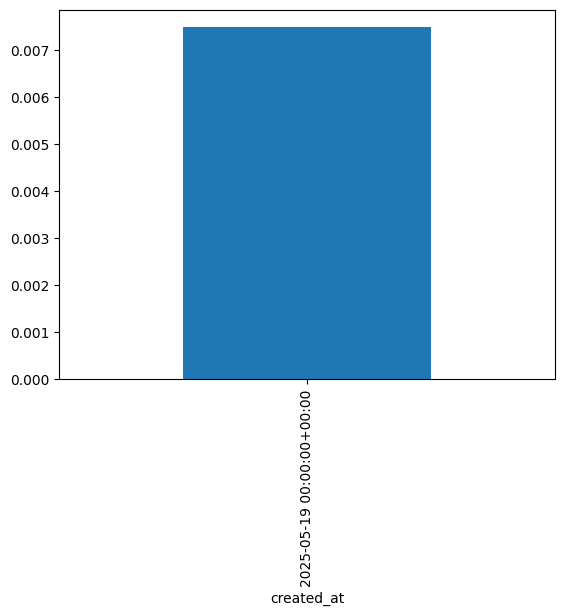

In [67]:
completions_df['cost'].resample('W-Mon').sum().sort_index().plot(kind='bar')